### Quantum Circuit Simulation with Enhanced Sampling
In this notebook, we're exploring the simulation of quantum circuits using enhanced sampling methods (non-adaptive case) (https://arxiv.org/abs/2006.09350). The goal is to estimate the expectation values of a Hamiltonian operator on a given quantum state, which is a common task in many quantum algorithms.

We start by defining an ansatz, which is a parameterized quantum circuit that we use to prepare the quantum state. The parameters of the ansatz are optimized to minimize the expectation value of the Hamiltonian.

We then create a simple circuit to sample the Hamiltonian on the ansatz. We calculate the expectation and exact expectation of the circuit.

Next, we iterate over each part of the Hamiltonian and calculate various quantities such as the variance, standard deviation, and pre-energy. We also update the frequency dictionary, which keeps track of the frequency of each outcome when sampling the quantum circuit.

After that, we calculate the exact energy of the system by sampling the exact expectation value of the circuit.

We then combine the pre and post sampling results to calculate the post-energy. We also update the frequency dictionary with the new samples.

Finally, we calculate the root-mean-squared error (RMSE) of the frequentist and enhanced methods. The RMSE is a measure of the differences between the values predicted by a model or an estimator and the values observed. We plot the RMSE as a function of the number of shots to visualize the performance of the methods.

This notebook demonstrates the use of enhanced sampling methods in quantum circuit simulation. These methods can potentially provide more accurate results with fewer quantum circuit evaluations, which is beneficial in quantum computing where resources are limited.

NOTE: too many layers in conjuntion with noise in the circuit tend to worsen the results of enhanced sampling.

![Frequentist vs Enhanced schema](../../doc/SamplingSchema.png)


In [1]:
import numpy as np
from qiskit.opflow import StateFn, PauliExpectation,Z,X,I,ListOp, AerPauliExpectation,ComposedOp
from qiskit.circuit.library import TwoLocal,EfficientSU2
from qiskit.opflow.state_fns import CircuitStateFn
from qiskit.opflow.converters import CircuitSampler
from qiskit import Aer
from qiskit.providers.aer import QasmSimulator
from qiskit.utils.quantum_instance import QuantumInstance
from qiskit.test.mock import FakeMontreal
from qiskit.providers.aer.noise import NoiseModel

import qiskit
print("Qiskit version:",qiskit.__version__)

from random import random,seed
import matplotlib.pyplot as plt



# This repo's library
from enhanced_sampling import EnhancedSampling

Qiskit version: 0.18.2


In [2]:
def create_simple_circuit(ansatz, pauli_operator):
    """
    Create a simple circuit to sample a Hamiltonian on an ansatz.

    Args:
        ansatz (QuantumCircuit): The ansatz.
        pauli_operator (Pauli): The Pauli operator.

    Returns:
        tuple: The expectation and exact expectation of the circuit.
    """

    # Create a circuit state function from the ansatz
    ansatz_state = CircuitStateFn(primitive=ansatz)

    # Compose the circuit state function with the Pauli operator to create a complete circuit
    complete_circuit = StateFn(pauli_operator, is_measurement=True).compose(ansatz_state)

    # Convert the complete circuit to an expectation value
    expectation = PauliExpectation().convert(complete_circuit)

    # Convert the complete circuit to an exact expectation value
    exact_expectation = AerPauliExpectation().convert(complete_circuit)

    return expectation, exact_expectation

def is_unitary(m):
    return np.allclose(np.eye(m.shape[0]), m.H * m)

def update_dict(old_dict, sampler, num_qubits):
    """
    Update the dictionary with the results of a quantum operation.

    Args:
        old_dict (dict): The original dictionary.
        sampler (Sampler): The sampler object that contains the operation list.
        num_qubits (int): The number of qubits involved in the operation.

    Returns:
        dict: The updated dictionary.
    """
    new_dict = old_dict.copy()
    events = sampler.oplist[1].execution_results['counts'].items()

    for key, item in events:
        binary_value = bin(int(key, 16))[2:].zfill(num_qubits)
        new_dict[binary_value] = new_dict.get(binary_value, 0) + item 

    return new_dict


def get_amplitudes(old_dict, num_shot):
    """
    Calculate the amplitudes from the counts in the dictionary.

    Args:
        old_dict (dict): The dictionary with counts.
        num_shot (int): The number of shots in the quantum operation.

    Returns:
        dict: The dictionary with calculated amplitudes.
    """
    return {key: np.sqrt(item / num_shot) for key, item in old_dict.items()}


def get_RMSE(results, true_value):
    """
    Calculate the Root Mean Square Error (RMSE) of the results.

    Args:
        results (dict): The dictionary with results.
        true_value (float): The true value for comparison.

    Returns:
        float: The calculated RMSE.
    """
    return np.sqrt(np.mean([(mu - true_value) ** 2 for mu in results.values()]))

def compute_variance(expected_operator, state_freq_dict):
    """
    Compute the variance of an expected operator given a state frequency dictionary.

    Args:
        expected_operator (OperatorBase): The expected operator.
        state_freq_dict (dict): The state frequency dictionary.

    Returns:
        float: The computed variance.
    """
    def calculate_variance(operator, state_freq_dict):
        """
        Calculate the variance of an operator.

        Args:
            operator (OperatorBase): The operator.
            state_freq_dict (dict): The state frequency dictionary.

        Returns:
            float: The calculated variance.
        """
        if isinstance(operator, ComposedOp):
            measurement = operator.oplist[0]
            average = measurement.eval(state_freq_dict)
            variance = sum(
                (v * (measurement.eval(b) - average)) ** 2
                for (b, v) in state_freq_dict.items()
            )
            return operator.coeff * variance

        elif isinstance(operator, ListOp):
            return operator.combo_fn([calculate_variance(op, state_freq_dict) for op in operator.oplist])

        return 0.0

    # Check if the input arguments are of the expected type
    if not isinstance(expected_operator, (ComposedOp, ListOp)):
        raise TypeError("expected_operator must be an instance of ComposedOp or ListOp.")
    if not isinstance(state_freq_dict, dict):
        raise TypeError("state_freq_dict must be a dictionary.")

    return calculate_variance(expected_operator, state_freq_dict)



## Initial  setup

First set up a generic hamiltonian as well as general variables

In [3]:
#Declare an Hamiltonian
H_1 = Z ^ Z ^ Z
H_2 = (X ^ I ^ I) + (I ^ X ^ I)
Hamiltonian =  H_1 + H_2 

print(Hamiltonian)

1.0 * ZZZ
+ 1.0 * XII
+ 1.0 * IXI


In [4]:
# Define global variables
Layers = 4  #Layers of enhanced circuit; stay between 1 and 6
fixed_x_angles = np.ones(2*Layers)*np.pi/2 # list of pi/2 ,to use CLF insteaf of ELF
use_noise = False
num_preshots=4000 
num_postshot=2000
repetitions = 1 #repeat the entire test n-times, to increase statistic in results
sample_every = 1000 # measure the energy every n-shots
n_points = 10000 #to use for binning

# Build circuits

We need an ansatz circuit, and operators to measure on it.
Here we first build the ansatz from EfficientSU(2), define a set of random angles to apply to it.
Then we create the simple circuit containing the anstaz and the operators to measure (the Hamiltonian parts)
After that, we combine the anstaz with layers of the enhance circuit using fixed x_angles on these layers (=pi/2) to use Chebyshev-like functions, so we can take multiple samples of the same circuit, instead of modifying after each shot(this would means using ELF)

 Random angles assigned to ansatz {ParameterVectorElement(θ[0]): 1.1680220570801747, ParameterVectorElement(θ[1]): 1.795686678025813, ParameterVectorElement(θ[2]): 1.2617255125328317, ParameterVectorElement(θ[3]): 2.2468982716755828, ParameterVectorElement(θ[4]): 5.363571190329344, ParameterVectorElement(θ[5]): 3.379151087751608, ParameterVectorElement(θ[6]): 6.178754944553304, ParameterVectorElement(θ[7]): 1.5628349995081818, ParameterVectorElement(θ[8]): 1.518474424412041, ParameterVectorElement(θ[9]): 0.49962993523475535, ParameterVectorElement(θ[10]): 2.1640358950166863, ParameterVectorElement(θ[11]): 2.451273703185537}


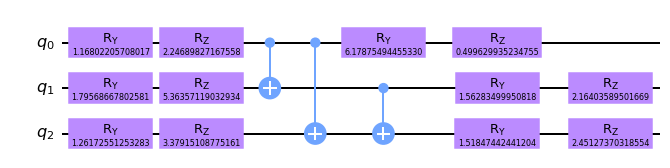

In [5]:
# Calculate the number of steps for pre-shots and post-shots
# Ensure at least 1 step
steps_pre = max(1,round(num_preshots / sample_every))
steps_post = max(1,round(num_postshot / sample_every))

# Create an ansatz using the EfficientSU2 method
# 'ry' and 'rz' are rotation gates, and 'reps' is the number of repetitions of the circuit
ansatz = EfficientSU2(Hamiltonian.num_qubits, ['ry','rz'], reps=1)

# Initialize a dictionary to hold the angles for the ansatz
angles_set = {}
# Assign random angles to each parameter
for param in ansatz.ordered_parameters:
    angles_set[param] = random() * 2 * np.pi

# Bind the random angles to the ansatz
ansatz_assigned = ansatz.bind_parameters(angles_set)

print(' Random angles assigned to ansatz',angles_set)

#Draw the ansatz circuit
ansatz_assigned.decompose().draw(output='mpl',filename='EfficientSU2')

In [6]:
#Backend and Quantum instance
backend=Aer.get_backend('qasm_simulator')
#simulator = Aer.get_backend('aer_simulator')
backend_sv = Aer.get_backend('statevector_simulator')



device_backend = FakeMontreal()
device = QasmSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)

if use_noise == False: 
    noise_model = None
    coupling_map = None

# SET UP INITIAL SAMPLING 
quantum_instance = QuantumInstance(backend=backend,
                                    shots=sample_every, #to adapt
                                    skip_qobj_validation = False,
                                    coupling_map=coupling_map,
                                    noise_model=noise_model)


print('Number of preshots',num_preshots)
print('Number of postshots',num_postshot)

Number of preshots 4000
Number of postshots 2000


## Phase 1: Initial pre-sampling (frequentist mode)

In [7]:
# Initialize a dictionary to hold all the data
data = {
    "pre_energy_freq": {},
    "std_dev_freq": {},
    "variance_freq": {},
    "freq_dict": {},
    "exact_energy": {},
    "exact_expectation": {},
    "expectation": {},
}

# Iterate over each part of the Hamiltonian
for H_part in Hamiltonian.to_pauli_op():
    print('Computing:',H_part)
    primitive = str(H_part)

    # Initialize dictionaries for this part of the Hamiltonian
    for key in data.keys():
        data[key][primitive] = {}

    # Create a simple circuit for this part of the Hamiltonian
    data["expectation"][primitive], data["exact_expectation"][primitive] = create_simple_circuit(ansatz_assigned, H_part)

    # Iterate over each step
    for step in range(steps_pre):
        # Initialize dictionaries for this step
        for key in ["variance_freq", "std_dev_freq", "pre_energy_freq"]:
            data[key][primitive][step] = {}

        # Iterate over each repetition
        for rep in range(repetitions):
            sampler = CircuitSampler(backend=quantum_instance , attach_results=True).convert(data["expectation"][primitive])
            operator_in_use = sampler.oplist[0]

            # Update the frequency dictionary
            if rep not in data["freq_dict"][primitive].keys(): 
                data["freq_dict"][primitive][rep] = {}
            data["freq_dict"][primitive][rep] = update_dict(data["freq_dict"][primitive][rep], sampler, Hamiltonian.num_qubits)

            # Calculate the amplitudes
            ampli_dict = get_amplitudes(data["freq_dict"][primitive][rep], (step+1)*sample_every)

            # Calculate the variance, standard deviation, and pre-energy
            data["variance_freq"][primitive][step][rep] = np.real(compute_variance(sampler, ampli_dict)/(num_preshots-1))
            data["std_dev_freq"][primitive][step][rep] = np.sqrt(data["variance_freq"][primitive][step][rep])
            data["pre_energy_freq"][primitive][step][rep] = operator_in_use.eval(ampli_dict).real

    # Calculate the exact energy
    sampler_exact = CircuitSampler(backend_sv).convert(data["exact_expectation"][primitive])
    data["exact_energy"][primitive] = sampler_exact.eval().real
    print('Exact (partial) energy = ', data["exact_energy"][primitive])

print('\nExact total Energy =', sum(data["exact_energy"].values()))


Computing: ZZZ
Exact (partial) energy =  0.2868678657867208
Computing: XII
Exact (partial) energy =  0.057729200917975426
Computing: IXI
Exact (partial) energy =  -0.1820023221878087

Exact total Energy = 0.16259474451688755


## Phase 2: Enhanced sampling vs Frequentist

First we gonna simulate the continuation of the frequentist approac

In [8]:

# Initialize a dictionary for post energy frequencies
data["post_energy_freq"] = {}

# Iterate over each part of the Hamiltonian
for H_part in Hamiltonian.to_pauli_op():
    primitive = str(H_part)
    print('\n',primitive,'freq event presampling \n',data["freq_dict"][primitive][0] ,data["pre_energy_freq"][primitive][steps_pre-1][0])
    data["post_energy_freq"][primitive] = {}

    # Combine pre and post sampling
    for step in range(steps_post):
        data["post_energy_freq"][primitive][step] = {}

        for rep in range(repetitions):
            sampler_2 = CircuitSampler(backend=quantum_instance, attach_results=True).convert(data["expectation"][primitive])
            data["freq_dict"][primitive][rep] = update_dict(data["freq_dict"][primitive][rep], sampler_2, Hamiltonian.num_qubits)
            operator_in_use = sampler_2.oplist[0]
            ampli_dict = get_amplitudes(data["freq_dict"][primitive][rep], num_preshots+((step+1)*sample_every))
            data["post_energy_freq"][primitive][step][rep] = operator_in_use.eval(ampli_dict).real

    print('Exact energy =', data["exact_energy"][primitive])
    print('Frequentist pre+post: energy', primitive, data["post_energy_freq"][primitive][steps_post-1][0], '\n \tevents', data["freq_dict"][primitive][0])



 ZZZ freq event presampling 
 {'101': 6, '010': 516, '100': 13, '110': 78, '001': 876, '000': 2204, '011': 269, '111': 38} 0.2785
Exact energy = 0.2868678657867208
Frequentist pre+post: energy ZZZ 0.28200000000000003 
 	events {'101': 8, '010': 767, '100': 24, '110': 112, '001': 1304, '000': 3345, '011': 381, '111': 59}

 XII freq event presampling 
 {'011': 248, '111': 46, '000': 975, '010': 525, '001': 337, '101': 496, '110': 92, '100': 1281} 0.04249999999999993
Exact energy = 0.057729200917975426
Frequentist pre+post: energy XII 0.05399999999999999 
 	events {'011': 379, '111': 64, '000': 1473, '010': 776, '001': 534, '101': 729, '110': 142, '100': 1903}

 IXI freq event presampling 
 {'101': 6, '010': 2002, '001': 831, '110': 11, '100': 84, '000': 685, '011': 335, '111': 46} -0.19699999999999987
Exact energy = -0.1820023221878087
Frequentist pre+post: energy IXI -0.1979999999999999 
 	events {'101': 12, '010': 3051, '001': 1221, '110': 16, '100': 123, '000': 1050, '011': 466, '111

### Enhanced sampling

Now we can test the enhance sampling. To later compare frequentist vs enhanced

In [9]:
#Initialize the EnhancedSampler
EnhanceSamplerTest = EnhancedSampling.EnhancedSampler(Hamiltonian,
                                                      Layers,
                                                      ansatz_assigned,
                                                      random_seed=44)

print('\nRepetition', repetitions)
fit_energy, fit_variance = EnhanceSamplerTest.eval(data["pre_energy_freq"], data["std_dev_freq"], quantum_instance, repetitions, steps_post, steps_pre)



Repetition 1


Sampling for ZZZ ...
Guesses: amplitude, mean, std_dev: 0.036584806215364585 1.281510705663847 0.0034249712200795793
Fit successful: Converged with popt: [0.03659026 1.28152585 0.00342583]
Guesses: amplitude, mean, std_dev: 0.0365905915636164 1.278339730637555 0.0034239180417332425
Fit successful: Converged with popt: [0.0366016  1.27835395 0.00342477]


Sampling for XII ...
Guesses: amplitude, mean, std_dev: 0.036482323891772514 1.5138739954731328 0.0034340406430913017
Fit successful: Converged with popt: [0.03649361 1.51385997 0.0034349 ]
Guesses: amplitude, mean, std_dev: 0.036482323891772514 1.5138739954731328 0.0034340406430913017
Fit successful: Converged with popt: [0.03649361 1.51385997 0.0034349 ]


Sampling for IXI ...
Guesses: amplitude, mean, std_dev: 0.03153589620934152 1.753900309921591 0.007565860560869514
Fit successful: Converged with popt: [0.03169626 1.75621317 0.00345908]
Guesses: amplitude, mean, std_dev: 0.02916477584872045 1.751022892096199 0.0068

In [10]:

freq_tot_energy = 0
enha_tot_energy = 0

for H_part in Hamiltonian.to_pauli_op():
    print()
    primitive = str(H_part)
    print(primitive)
    print('Exact energy =', data["exact_energy"][primitive])
    print('Initial energy=', sum(data["pre_energy_freq"][primitive][steps_pre-1].values())/repetitions, 'err=', sum(data["std_dev_freq"][primitive][steps_pre-1].values())/repetitions)
    print('Frequentist energy', sum(data["post_energy_freq"][primitive][steps_post-1].values())/repetitions)
    print('Enhanced Energy =', sum(fit_energy[primitive][steps_post-1].values())/repetitions, 'err=', np.sqrt(sum(fit_variance[primitive][steps_post-1].values())/repetitions))

    freq_tot_energy += sum(data["post_energy_freq"][primitive][steps_post-1].values())/repetitions
    enha_tot_energy += sum(fit_energy[primitive][steps_post-1].values())/repetitions

print('\nTotal Frequentist energy', freq_tot_energy,
      '\nTotal Enhanced energy', enha_tot_energy) 
print('\nTotal Exact energy', sum(data["exact_energy"].values()))



ZZZ
Exact energy = 0.2868678657867208
Initial energy= 0.2785 err= 0.01518772873987645
Frequentist energy 0.28200000000000003
Enhanced Energy = 0.2882900719089045 err= 0.003279340607456776

XII
Exact energy = 0.057729200917975426
Initial energy= 0.04249999999999993 err= 0.01579907719488871
Frequentist energy 0.05399999999999999
Enhanced Energy = 0.056905268704221315 err= 0.0034293158988178076

IXI
Exact energy = -0.1820023221878087
Initial energy= -0.19699999999999987 err= 0.015503478301976787
Frequentist energy -0.1979999999999999
Enhanced Energy = -0.18174248042214922 err= 0.0034359625364898836

Total Frequentist energy 0.13800000000000012 
Total Enhanced energy 0.16345286019097657

Total Exact energy 0.16259474451688755


### Plot the results

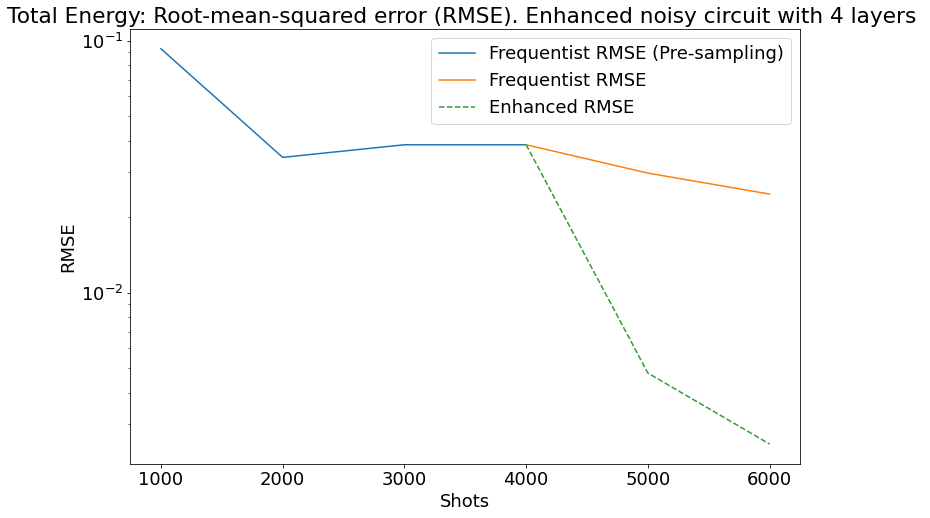

In [11]:
plt.rcParams.update({'font.size': 18})

lenH = len(Hamiltonian.to_pauli_op())
freq_rmse = np.zeros((lenH,steps_post+1))
enha_rmse = np.zeros((lenH,steps_post+1))
pre_freq_rmse = np.zeros((lenH,steps_pre))
plt.figure(figsize=(12,8))
for h,H_part in enumerate(Hamiltonian.to_pauli_op()):
    primitive = str(H_part)
    for t in range(steps_pre):
        pre_freq_rmse[h,t] = get_RMSE(data['pre_energy_freq'][primitive][t],data['exact_energy'][primitive])
    freq_rmse[h,0]= pre_freq_rmse[h,steps_pre-1]
    enha_rmse[h,0]= pre_freq_rmse[h,steps_pre-1]
    for t in range(0,steps_post):
        #print(pre_energy_freq[primitive][t])
        freq_rmse[h,t+1] = get_RMSE(data['post_energy_freq'][primitive][t],data['exact_energy'][primitive])
        enha_rmse[h,t+1] = get_RMSE(fit_energy[primitive][t],data['exact_energy'][primitive])
plt.plot(np.asarray(range(1,steps_pre+1))*sample_every, 
         np.sum(pre_freq_rmse,axis=0), label="Frequentist RMSE (Pre-sampling)" )
plt.plot(num_preshots+np.asarray(range(steps_post+1))*sample_every, np.sum(freq_rmse,axis=0) , label="Frequentist RMSE")
plt.plot(num_preshots+np.asarray(range(steps_post+1))*sample_every, np.sum(enha_rmse,axis=0) ,linestyle = '--', label="Enhanced RMSE")
#plt.plot(range(num_steps),-0.01+1/np.sqrt(range(1000,1000+num_steps)))
plt.yscale('log')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Shots')
plt.title('Total Energy: Root-mean-squared error (RMSE). Enhanced noisy circuit with '+str(Layers)+' layers ')
plt.savefig('RMSE_'+str(Layers)+'__rep'+str(repetitions)+'.png')